In [1]:
from util import go_to_project_root
go_to_project_root()

CWD cambiado a la raíz del proyecto: /home/epsilon/Documents/doctorado/S2/ENSTA630/tareas/HW2


# Problema 1

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from source.fit.inference.test_chow import test_chow

from source.data.loaders import create_dataset
from source.models.var import VAR
from source.data.transform import create_var_dataset
from source.display.hw import hw2 as plots
from source.display.hw.hw1 import save_figure
from source.fit.bootstrap import bootstrap_IRF_intervals

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Cargar datos

In [16]:
path = './data/base_25.xls'
dataset = create_dataset(path, problem=5)

[INFO] ¡Datos cargados exitosamente!


In [17]:
i_reshaped = dataset['i'][12:]
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T

In [18]:
X.shape

(185, 3)

### Modelo

In [31]:
p = 2          # rezagos
n = X.shape[1] # numero de variables
model = VAR(inp_dim=n, 
            c=0,
            p=p)
model._is_stationary()

np.False_

In [35]:
IRF_low, IRF_up = bootstrap_IRF_intervals(X, 
                                          p, 
                                          H=5, n_boot=1000, alpha=0.05)

In [47]:
IRF_low.shape, IRF_up.shape

((5, 3, 3), (5, 3, 3))

<Axes: >

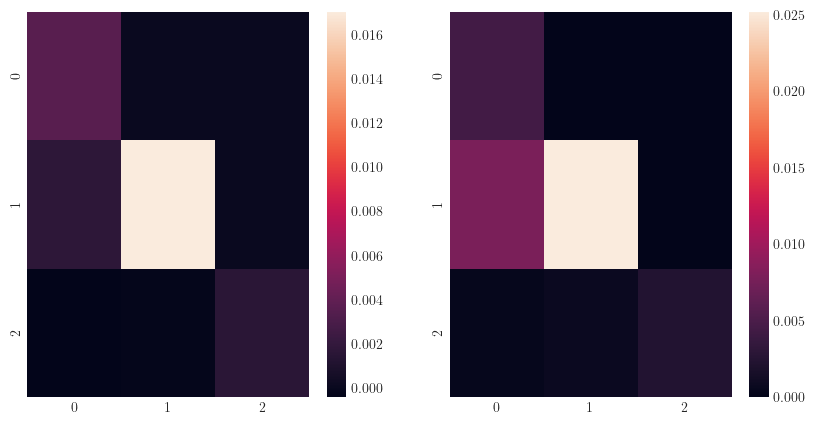

In [46]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(IRF_low[0], ax=axes[0]) 
sns.heatmap(IRF_up[0], ax=axes[1])   

In [218]:
err = model.fit(X)
model._is_stationary()

print(model)

         Vector Autoregression (VAR) Model Summary          
VAR(p=2, n=3)
Estacionario: Sí (Max Eigenvalue: 0.9644)
------------------------------------------------------------
                 Propiedades de Largo Plazo                 
Media Incondicional:
[0.0396 0.0271 0.0439]

D.E. Incondicional:
[0.0244 0.0468 0.0253]
------------------------------------------------------------
                  Coeficientes del Modelo                   
Intercepto (c):
[ 0.0017  0.0099 -0.0004]

Matriz Phi_1:(3, 3)
Matriz Phi_2:(3, 3)
------------------------------------------------------------
          Matriz de Covarianza de Residuos (Omega)          
Omega: (3, 3)



### IRF: Cholesky 

In [219]:
cirf = model.get_irf(H=10, method='cholesky')
girf = model.get_irf(H=10, method='girf')

In [221]:
cirf.shape, girf.shape

((11, 3, 3), (11, 3, 3))

In [ ]:
pos_fit_data = model.sample(len(X))

✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/true_gen.pdf


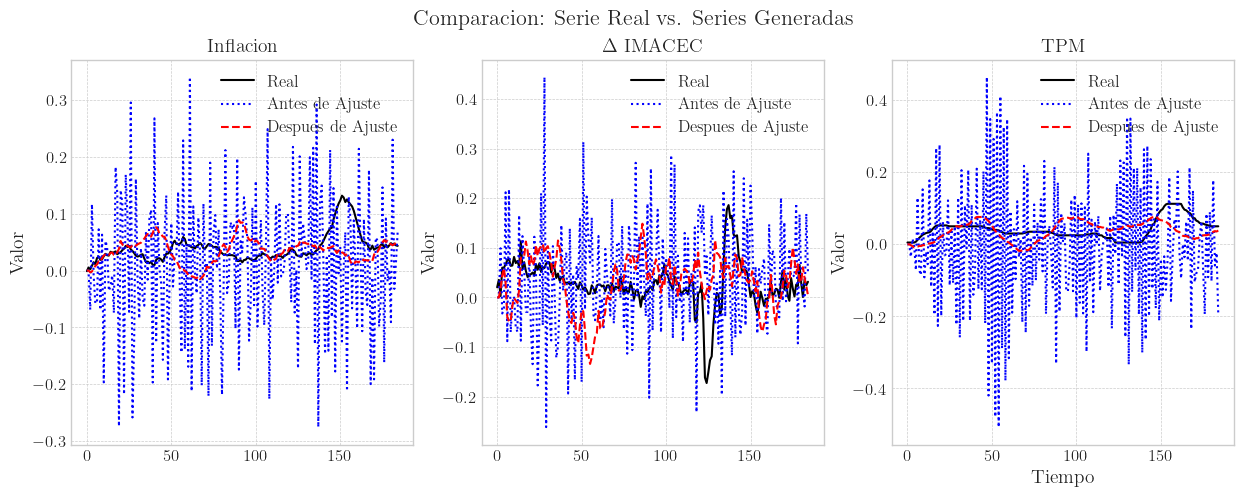

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plots.plot_real_vs_generated(X, pre_fit_data, pos_fit_data, fig=fig, axes=axes,
                             variable_names=['Inflacion', r'$\Delta$ IMACEC', 'TPM'])
save_figure(fig, './presentation/figures/hw2/p2/true_gen.pdf')